In [37]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
dataset=pd.read_csv('/content/drive/My Drive/dataset.csv')
dataset.dropna(inplace = True)
dataset

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [40]:
print("number of tweets belonging to classes 0,1 and 2")
dataset.groupby('class')['id'].nunique()


number of tweets belonging to classes 0,1 and 2


class
0     1430
1    19190
2     4163
Name: id, dtype: int64

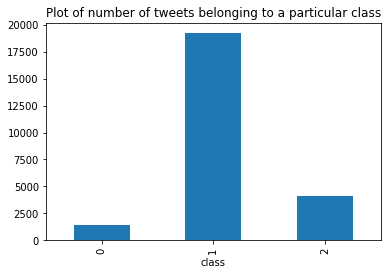

In [41]:
dataset.groupby('class')['id'].nunique().plot(kind='bar',title='Plot of number of tweets belonging to a particular class')

In [42]:
dataset0 = dataset[dataset['class'] == 0]
dataset1 = dataset[dataset['class'] == 1]
dataset2 = dataset[dataset['class'] == 2]

count0 = dataset0.shape[0]
count1 = dataset1.shape[0]
count2 = dataset2.shape[0]
print(count0, count1, count2)

1430 19190 4163


In [43]:
dataset1_under = dataset1.sample(count2)

dataset = pd.concat([dataset0, dataset1_under, dataset2], axis = 0)
dataset.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [44]:
print("number of tweets belonging to classes 0,1 and 2")
dataset.groupby('class')['id'].nunique()


number of tweets belonging to classes 0,1 and 2


class
0    1430
1    4163
2    4163
Name: id, dtype: int64

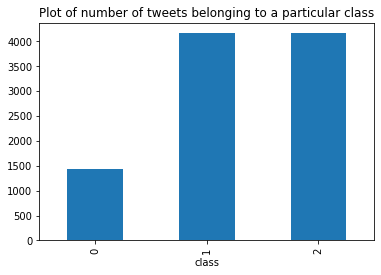

In [45]:
dataset.groupby('class')['id'].nunique().plot(kind='bar',title='Plot of number of tweets belonging to a particular class')

In [15]:
dataset.to_csv('/content/drive/My Drive/resampled_dataset.csv')

# **Data Cleaning**

In [46]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
stop_words= set(stopwords.words('english'))

In [49]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)


# **Word2Vec model to get the word embedings.**

In [51]:
model = Word2Vec(dataset["tweet"].values, size=50, window=5, min_count=1, workers=4)

In [52]:
def get_features(tweet):
    features=[]
    for word in tweet:
        features.append(model.wv[word])
    return np.mean(features,0)

In [53]:
dataset["features"]=dataset["tweet"].apply(get_features)

In [54]:
data=[]
for i in dataset["features"].values:
    temp=[]
    for j in i:
        temp.append(j)
    data.append(temp)
data=np.array(data)

In [55]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(dataset["class"].values, classes=[0, 1, 2])
n_classes = Y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [56]:
print(X_train)
print(y_train)

[[ 2.3332307e-01 -1.8016039e-01 -2.1027438e-01 ...  4.8104893e-02
  -1.2326883e-03 -1.3633351e-01]
 [ 2.6428220e-01 -2.0753844e-01 -2.3867933e-01 ...  5.1335398e-02
  -2.1836488e-03 -1.5071563e-01]
 [ 6.2795800e-01 -4.8645940e-01 -5.5809444e-01 ...  1.1187654e-01
   3.7142991e-03 -3.5209909e-01]
 ...
 [ 5.7918221e-01 -4.4496015e-01 -5.1466596e-01 ...  1.0742350e-01
   5.6844787e-04 -3.3092803e-01]
 [ 3.8018209e-01 -2.8660423e-01 -3.3559188e-01 ...  7.2462976e-02
   8.5337192e-04 -2.1802168e-01]
 [ 7.6789558e-01 -5.8197141e-01 -6.7981464e-01 ...  1.5071347e-01
  -6.2024458e-03 -4.3529090e-01]]
[[0 0 1]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 0 1]]


# **LOGISTIC REGRESSION MODEL**

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

F1 Score:  0.541970802919708
Precision Score:  0.6669161676646707
Recall Score:  0.45645491803278687
Accuracy:  0.45645491803278687


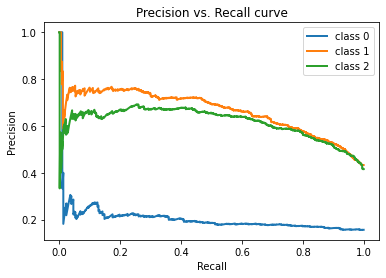

In [58]:
lr_clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'))
lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", lr_clf.score(X_test,y_test))

y_score = lr_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

# ***SVM MODEL***

F1 Score:  0.4894801980198021
Precision Score:  0.61796875
Recall Score:  0.4052254098360656
Accuracy:  0.4052254098360656


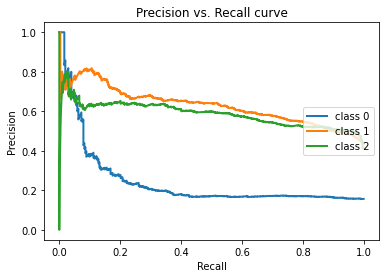

In [59]:
svm_clf = OneVsRestClassifier(svm.SVC(gamma='scale', probability=True))
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", svm_clf.score(X_test,y_test))

y_score = svm_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "center right")
plt.title("Precision vs. Recall curve")
plt.show()

<h2><b>BERT + CNN</b></h2>
<h3><b>Data Cleaning for BERT</b><h3>

In [60]:
!pip3 install transformers
!pip3 install nltk

In [61]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [62]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights = 'bert-base-uncased'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)


In [63]:
max_seq = 27
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df["tweet"].values
    ]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])
def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)
def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [64]:
max = 0
for i in dataset["tweet"]:
  if len(i) > max:
    max = len(i)
print(max)


31


In [ ]:
for i in range(0,len(dataset["tweet"])):
  dataset["tweet"][i] = " ".join(dataset["tweet"][i])

In [66]:
dataset["tweet"]

85       [blackman, tide, whalelookyhere, howdydowdy, q...
89       [cb, baby, white, thunduh, alsarabsss, hes, be...
110      [devilgrimz, vigxrarts, fucking, gay, blacklis...
184      [markroundtreejr, lmfaoooo, hate, black, peopl...
202      [nochillpaz, least, nigger, co, rgja, cfoit, l...
                               ...                        
24736    [yaya, ho, cute, avi, tho, rt, vivala, ari, id...
24737    [yea, n, tel, new, friend, friends, kno, allow...
24767    [know, say, early, bird, gets, worm, puts, gum...
24779    [gone, broke, wrong, heart, baby, drove, redne...
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Name: tweet, Length: 9756, dtype: object

In [67]:
indices = tokenize_and_pad_text(dataset, max_seq)

[no,_] = list(indices.shape)

In [68]:
stepSize = 32
X = np.empty([0,max_seq,768])

for i in range(0,no,stepSize):
  if no - i <= stepSize:
    n = no
  else:
    n = i+stepSize
  with torch.no_grad():
    x = bert_model(indices[i:n,:])[0].detach().numpy()
  X = np.vstack([X,x])

In [69]:
label_col = ["class"]
Y = targets_to_tensor(dataset,label_col)

In [70]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2,random_state=42)
x_train = torch.tensor(x_train,dtype=torch.float32)
x_val = torch.tensor(x_val,dtype=torch.float32)

In [71]:
loss_func = nn.CrossEntropyLoss()

In [73]:
class HTSPC_CNN(nn.Module):
    def __init__(self,embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout,static):
        super(HTSPC_CNN, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.emed_layer = nn.Embedding(V, D)
        
        self.conv1 = nn.ModuleList([nn.Conv2d(1,Co,(K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        
        self.lin1 = nn.Linear(len(Ks)* Co, 3)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self,xb):
        if self.static:
            x = Variable(xb)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.conv1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.lin1(x)
        return x

In [74]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = yb.squeeze_()
    # print(model(xb).squeeze_())
    # print(yb)  
    loss = loss_func(model(xb.float()), yb.long())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [75]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [76]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [77]:
bs = 128
epochs = 50
learning_rate = 0.0001

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val  , y_val  )

embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]

print(class_num)

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

train_dl, valid_dl = get_data(train_dataset, valid_dataset, bs)
model = HTSPC_CNN(embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout,static)

opt = torch.optim.Adam(model.parameters(), lr = learning_rate)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


1
0 1.0173227884730354
1 0.9922809698542611
2 0.9544156477099559
3 0.9278687883595951
4 0.9055814576930687
5 0.8876323162532244
6 0.8735788054153567
7 0.8592680086855029
8 0.8428153190456453
9 0.8379321254667689
10 0.8297982694672756
11 0.8209365791961795
12 0.8132107785490693
13 0.8032997387354491
14 0.799771963572893
15 0.795743215279501
16 0.790366744408842
17 0.7850446935559883
18 0.7824664418814612
19 0.7781990248648847
20 0.7726328255700283
21 0.771253803714377
22 0.7711600221571375
23 0.7658186662392538
24 0.7616971897297218
25 0.7595422873731519
26 0.7554735111408546
27 0.7511640386503251
28 0.7465235463908462
29 0.7446471902190662
30 0.7386685815013823
31 0.738293321406255
32 0.7341480870715907
33 0.7311174273490906
34 0.7290076642739968
35 0.7263678664066753
36 0.7286004854030297
37 0.7219563331760344
38 0.7215411721682939
39 0.7152431734272691
40 0.7175902167304617
41 0.7168630771949643
42 0.7163593104628266
43 0.7122659292377409
44 0.7097699378357559
45 0.7111314466742219
4

In [78]:
_,preds = torch.max(model(x_val),1)

In [79]:
print(accuracy_score(preds.detach().numpy(),y_val.detach().numpy()))

0.6997950819672131


In [80]:
f = f1_score(preds.detach().numpy(),y_val.detach().numpy(), average='weighted')
print("F1 Score: ", f)
p = precision_score(preds.detach().numpy(),y_val.detach().numpy(), average='weighted')
print("Precision Score: ", p)
r = recall_score(preds.detach().numpy(),y_val.detach().numpy(), average='micro')
print("Recall Score: ", r)

F1 Score:  0.7575831141415115
Precision Score:  0.8266487765568528
Recall Score:  0.6997950819672131


<h2><b>LSTM</b><h2>

In [97]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [98]:
dataset=pd.read_csv('/content/drive/My Drive/resampled_dataset.csv')
dataset.dropna(inplace = True)

In [99]:
dataset

,Unnamed: 0,id,count,hate_speech,offensive_language,neither,class,tweet
0,85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
1,89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
2,110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
3,184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
4,202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."
...,...,...,...,...,...,...,...,...
9751,24736,25249,3,0,0,3,2,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
9752,24737,25250,3,0,1,2,2,yea so about @N_tel 's new friend.. all my fri...
9753,24767,25280,3,0,1,2,2,"you know what they say, the early bird gets th..."
9754,24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."


In [100]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    return tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)

In [101]:
dataset.rename(columns={"tweet":"text","class":"label"},inplace=True)

In [102]:
dataset = dataset.reindex(columns = ['label','text'])
dataset

,label,text
0,0,blackman tide whalelookyhere howdydowdy queer...
1,0,cb baby white thunduh alsarabsss hes a beaner...
2,0,devilgrimz vigxrarts you re fucking gay black...
3,0,markroundtreejr lmfaoooo i hate black people ...
4,0,nochillpaz at least i m not a nigger t co rgj...
...,...,...
9751,2,yaya ho cute avi tho rt vivala ari i had no id...
9752,2,yea so about n tel s new friend all my friends...
9753,2,you know what they say the early bird gets the...
9754,2,you ve gone and broke the wrong heart baby and...


In [103]:
from sklearn.model_selection import train_test_split
train_full,test = train_test_split(dataset,train_size=0.8)


In [104]:
train, val = train_test_split(train_full,train_size=0.75)

In [105]:
train.to_csv("/content/drive/My Drive/train.csv",index=False)
test.to_csv("/content/drive/My Drive/test.csv",index=False)
val.to_csv("/content/drive/My Drive/valid.csv",index=False)

In [106]:
from torchtext.data import Field, TabularDataset, BucketIterator
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)

In [107]:
fields = [('label',label_field),('text', text_field)]

In [108]:
train, valid, test = TabularDataset.splits(path="./", train = '/content/drive/My Drive/train.csv', validation = '/content/drive/My Drive/valid.csv', test = '/content/drive/My Drive/test.csv',
                                           format='CSV', fields=fields, skip_header=True)

In [109]:
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),device="cpu",
                            sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),device="cpu",
                            sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),device="cpu",
                            sort=True, sort_within_batch=True)

In [110]:
text_field.build_vocab(train, min_freq=3)

In [111]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(2*dimension, 3)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_out = torch.softmax(text_fea,dim=1)

        return text_out

In [112]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [113]:
from sklearn.preprocessing import label_binarize
device = "cpu"
def train_model(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "./",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels,(tweet, tweet_len)), _ in train_loader:
            tweet = tweet.to(device)
            tweet_len = tweet_len.to(device)            
            output = model(tweet, tweet_len)
            labels = labels.long()
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels,(tweet, tweet_len)), _ in valid_loader:
                        tweet = tweet.to(device)
                        tweet_len = tweet_len.to(device)
                        output = model(tweet, tweet_len)
                        labels = labels.long()
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [91/1830], Train Loss: 0.8289, Valid Loss: 0.7674
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/10], Step [182/1830], Train Loss: 0.8015, Valid Loss: 0.7741
Epoch [2/10], Step [273/1830], Train Loss: 0.7307, Valid Loss: 0.7554
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/10], Step [364/1830], Train Loss: 0.7529, Valid Loss: 0.7736
Epoch [3/10], Step [455/1830], Train Loss: 0.7007, Valid Loss: 0.7301
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [3/10], Step [546/1830], Train Loss: 0.7428, Valid Loss: 0.7349
Epoch [4/10], Step [637/1830], Train Loss: 0.6934, Valid Loss: 0.7282
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/10], Step [728/1830], Train Loss: 0.7723, Valid Loss: 0.8229
Epoch [5/10], Step [819/1830], Train Loss: 0.7373, Valid Loss: 0.7470
Epoch [5/10], Step [910/1830], Train Loss: 0.7336, Valid Loss: 0.7322
Epoch [6/10], Step [1001/1830], Train Loss: 0

Model loaded from <== ./metrics.pt


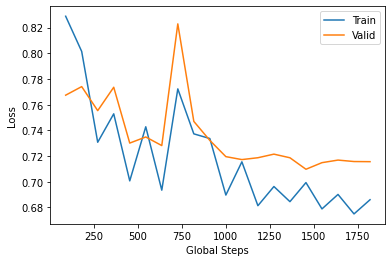

In [114]:
import matplotlib.pyplot as plt
train_loss_list, valid_loss_list, global_steps_list = load_metrics("." + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [115]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        correct = 0
        for (labels, (tweet, tweet_len)), _ in test_loader:           
            labels = labels.long()
            tweet = tweet.to(device)
            tweet_len = tweet_len.to(device)
            output = model(tweet, tweet_len)

            output = torch.argmax(output,dim=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
        for i,val in enumerate(y_pred):
            if y_true[i]==y_pred[i]:
                correct+=1
        print("Accuracy",correct/len(y_pred))
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint("." + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== ./model.pt
Accuracy 0.8345286885245902
